# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

#part a

#Compute squared loss
def comp_square_loss(a, b, x, y, dy):
    sq_loss = ((y-(a*x+b))/dy)**2
    return sq_loss
    
#part b
a = np.arange(-500,500,1)/10
b = np.arange(-500,500,1)

A,B = np.meshgrid(a,b)
likelihood_mesh,l = np.meshgrid(a,b)
for idxa, A in enumerate(a):
    for idxb, B in enumerate(b):
        likelihood_mesh[idxa][idxb] = -(1/2)*np.sum(comp_square_loss(A,B,x,y,dy))



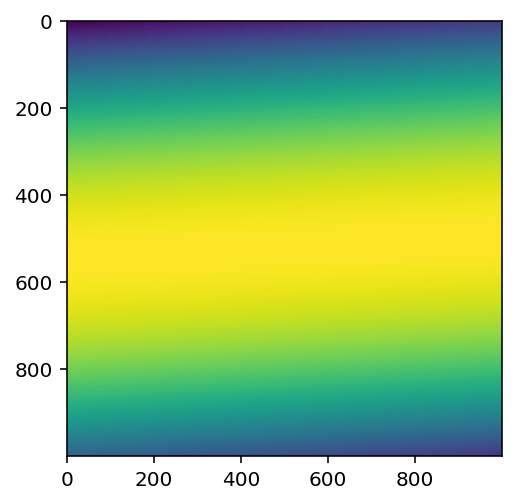

In [3]:
plt.imshow(likelihood_mesh)

In [4]:
np.amax(likelihood_mesh)

-145.02774455056402

In [5]:
from numpy import unravel_index
a_loc,b_loc=(unravel_index(likelihood_mesh.argmax(), likelihood_mesh.shape))
a_param = a[a_loc]
b_param = b[b_loc]
print('a = ', a_param)
print('b = ',b_param)

a =  1.1
b =  209


Text(0.5, 1.0, 'question 1b')

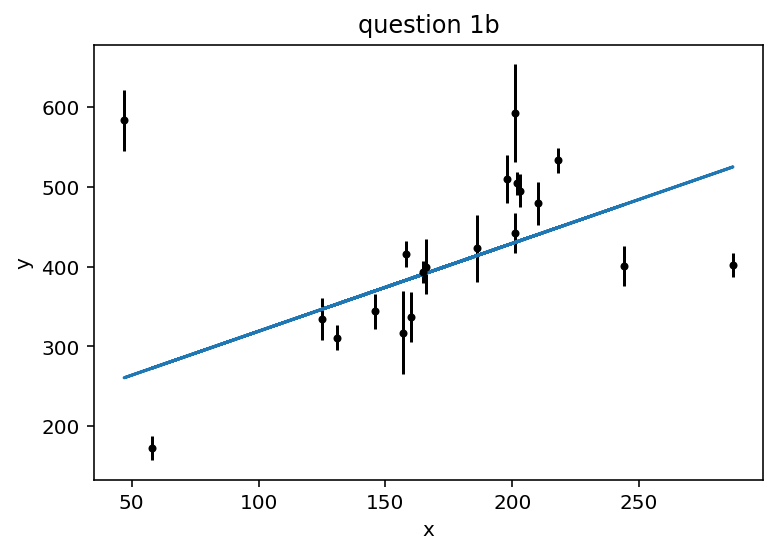

In [6]:
plt.errorbar(x,y,dy,fmt='.k')
x_arr = np.linspace(0,300)
plt.plot(x,x*a_param+b_param)
plt.xlabel('x')
plt.ylabel('y')
plt.title('question 1b')

In [7]:
#Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the 
#data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
#part c
import astropy as ap
#sigma clip residuals with sigma of 3
residuals = y-(x*a_param+b_param)
#if residual is more than three dy away, get rid of the point
mask = np.full(len(x),True)
for idx, residual in enumerate(residuals):
    if np.abs(residual) > 3*dy[idx]:
        mask[idx]=False

In [8]:
mask

array([ True, False, False, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True])

In [9]:
import numpy.ma as ma
x_masked = x[mask]
y_masked = y[mask]
dy_masked = dy[mask]

Text(0, 0.5, 'y')

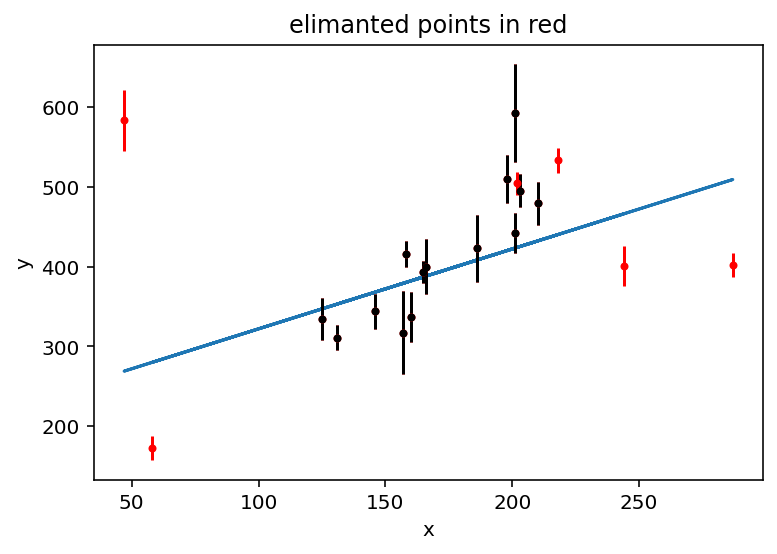

In [10]:
plt.plot(x,x*1+222)
plt.errorbar(x,y,dy,fmt='.r')
plt.errorbar(x_masked,y_masked,dy_masked,fmt='.k')
plt.title('elimanted points in red')
plt.xlabel('x')
plt.ylabel('y')

In [11]:
a = np.arange(-500,500,1)/10
b = np.arange(-500,500,1)

A,B = np.meshgrid(a,b)
likelihood_mesh_masked,l = np.meshgrid(a,b)
for idxa, A in enumerate(a):
    for idxb, B in enumerate(b):
        likelihood_mesh_masked[idxa][idxb] = -(1/2)*np.sum(comp_square_loss(A,B,x_masked,y_masked,dy_masked))


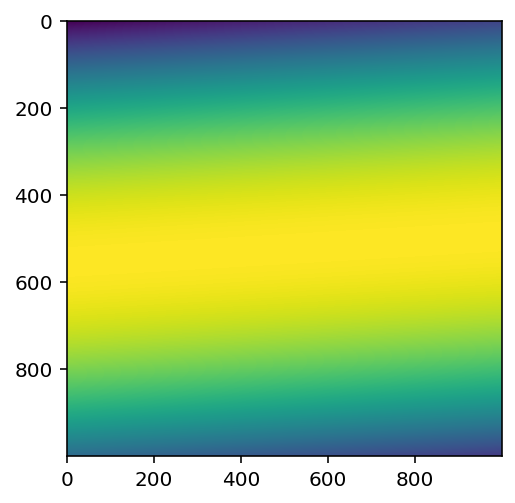

In [12]:
plt.imshow(likelihood_mesh_masked)

In [13]:
from numpy import unravel_index
a_loc,b_loc=(unravel_index(likelihood_mesh_masked.argmax(), likelihood_mesh_masked.shape))
a_param = a[a_loc]
b_param = b[b_loc]
print('a = ',a_param)
print('b = ',b_param)

a =  2.2
b =  35


Text(0.5, 1.0, 'part c, sigma clipped')

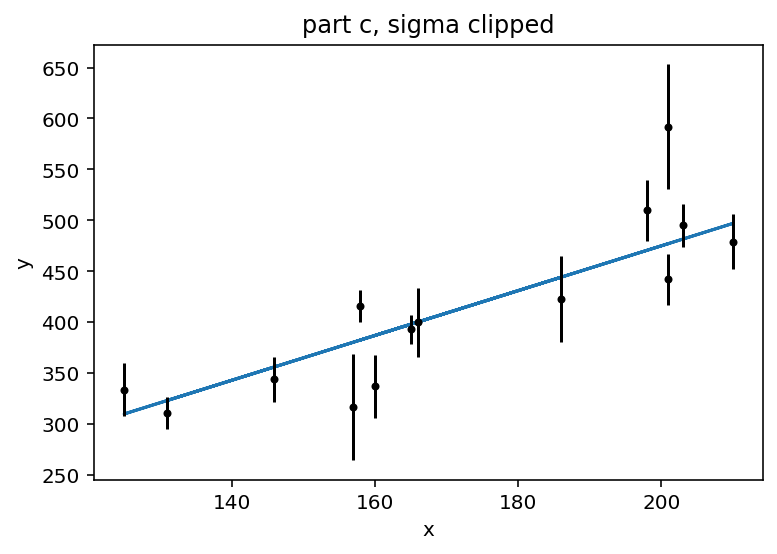

In [14]:
plt.plot(x_masked,x_masked*a_param+b_param)
# plt.errorbar(x,y,dy,fmt='.r')
plt.errorbar(x_masked,y_masked,dy_masked,fmt='.k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('part c, sigma clipped')

In [15]:
masked_residuals = x_masked-x_masked*a_param+b_param

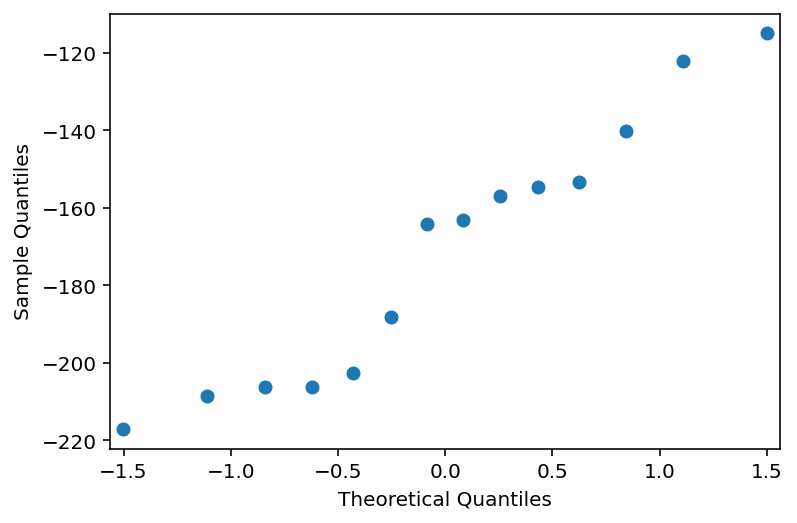

In [16]:
#make qq plot
import statsmodels.api as sm
sm.qqplot(masked_residuals);
#it looks pretty straight!

In [17]:
#Define a new likelihood function that implements the Huber loss, 
#also incorporating the measurement uncertainties 𝑑𝑦 (10 pts)
#part d

#choose delta = .1
def comp_huber_loss(a, b, x, y, dy, delta):
    eq = ((y-(a*x+b))/dy)
    if np.abs(eq)<=delta:
        huber_loss = ((eq)**2)/2
    else:
        huber_loss = delta*(np.abs(eq)-.5*delta)
    return huber_loss
def sum_huber(a,b,x,y,dy,delta):
    summed=0
    for i in range(len(x)):
        summed += comp_huber_loss(a,b,x[i],y[i],dy[i],delta)
    return summed



In [18]:
#Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, 
#except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - 
#QQ plot of the residuals (10 pts)
from scipy import optimize

def f(params,x,y,dy,delta):
    a,b = params
    return(sum_huber(a,b,x,y,dy,delta))
guess=[2,50]
minimum = optimize.fmin(f, guess,(x,y,dy,.1))
print(minimum)

Optimization terminated successfully.
         Current function value: 5.072789
         Iterations: 53
         Function evaluations: 99
[ 1.98827325 64.06596212]


Text(0.5, 1.0, 'question 1e')

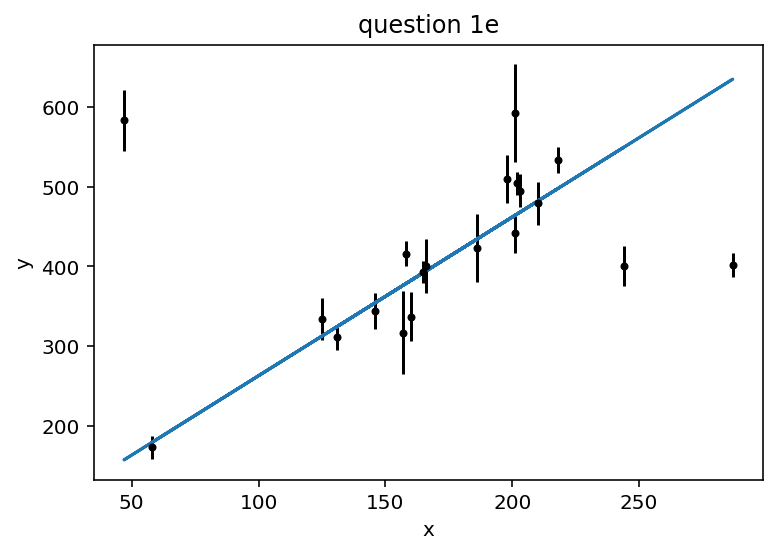

In [22]:
plt.errorbar(x,y,dy,fmt='.k')
plt.plot(x,x*minimum[0]+minimum[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('question 1e')

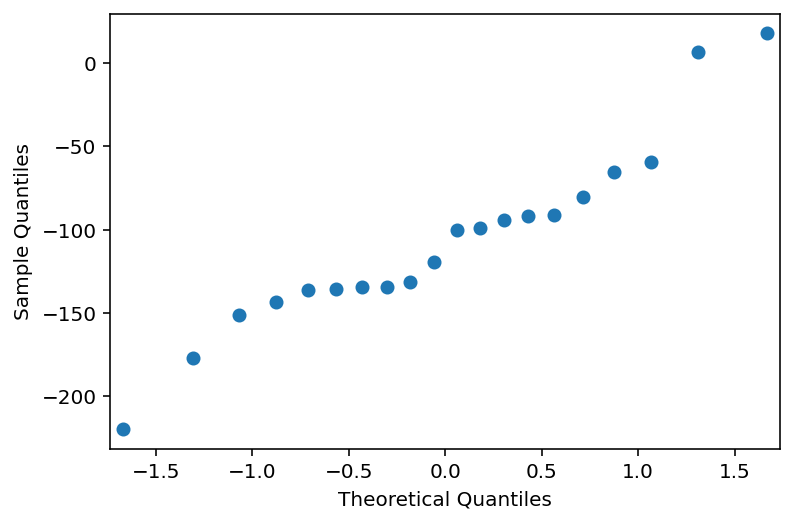

In [23]:
residuals = x-x*minimum[0]+minimum[1]
#make qq plot
import statsmodels.api as sm
sm.qqplot(residuals);
#it looks pretty straight!

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [24]:
#Split the data into LMC and SMC, and then again by mode F and 1, and plot the W on the y-axis vs log(P1) on x. 
#Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read in the csv data file using Pandas
cep = pd.read_csv("Cepheids.csv")
print(cep.columns)


Index(['name', 'RA0', 'Decl0', 'Mode', 'Cloud', 'W', 'logP1', 'VI'], dtype='object')


In [25]:
#select Cepheids belonging to the LMC and SMC clouds with F and 1 modes
lmcf = cep[(cep['Cloud'] == 'LMC') & (cep['Mode'] == 'F')]
smcf = cep[(cep['Cloud'] == 'SMC') & (cep['Mode'] == 'F')]

lmc1 = cep[(cep['Cloud'] == 'LMC') & (cep['Mode'] == '1')]
smc1 = cep[(cep['Cloud'] == 'SMC') & (cep['Mode'] == '1')]

Text(0.5, 1.0, 'Wesenheit Index vs log Period')

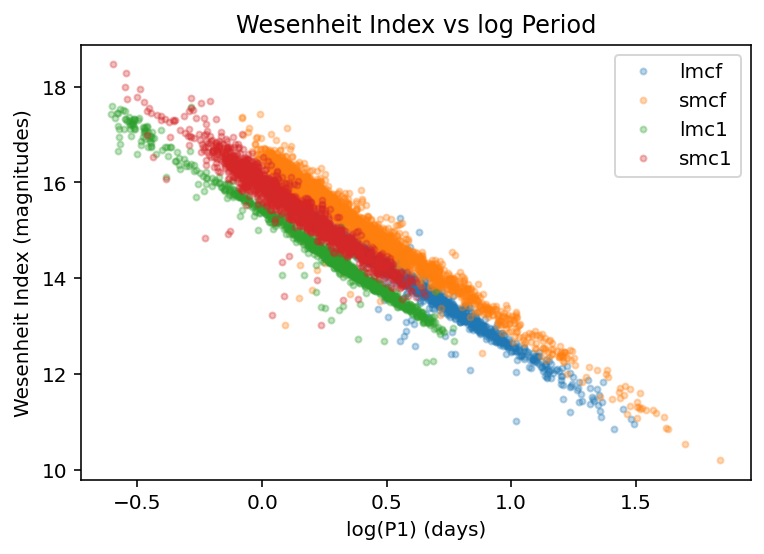

In [26]:
plt.plot(lmcf.loc[:,"logP1"],lmcf.loc[:,"W"],".",label = 'lmcf',alpha=.3)
plt.plot(smcf.loc[:,"logP1"],smcf.loc[:,"W"],".",label = 'smcf',alpha=.3)
plt.plot(lmc1.loc[:,"logP1"],lmc1.loc[:,"W"],".",label = 'lmc1',alpha=.3)
plt.plot(smc1.loc[:,"logP1"],smc1.loc[:,"W"],".",label = 'smc1',alpha=.3)
plt.legend()
plt.xlabel("log(P1) (days)")
plt.ylabel("Wesenheit Index (magnitudes)")
plt.title("Wesenheit Index vs log Period")

Optimization terminated successfully.
         Current function value: 8.155255
         Iterations: 63
         Function evaluations: 121


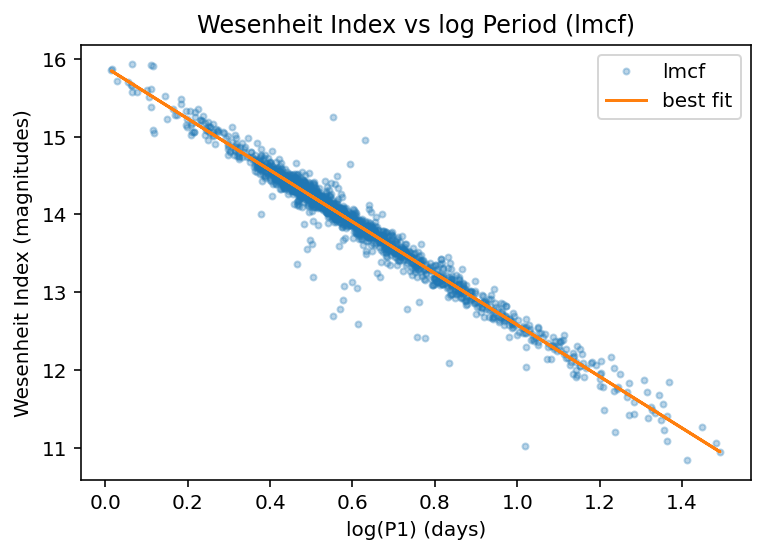

W =  -3.318 log(P1) +  15.894
Optimization terminated successfully.
         Current function value: 24.566120
         Iterations: 62
         Function evaluations: 118


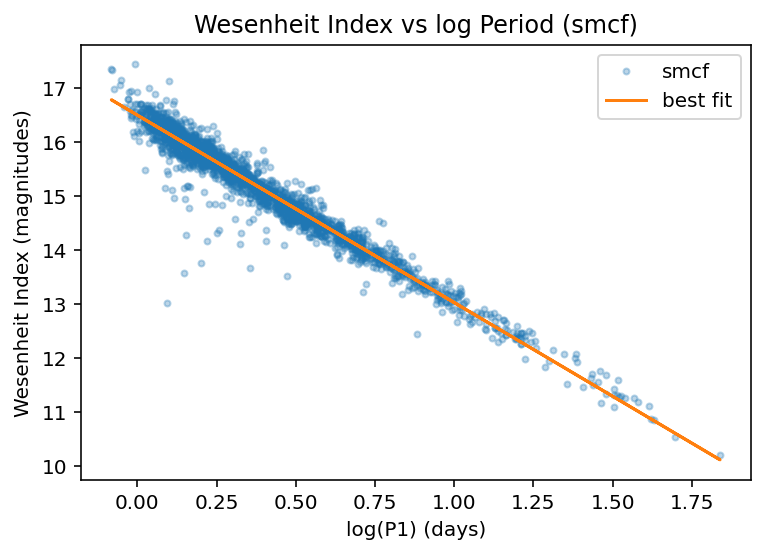

W =  -3.474 log(P1) +  16.5
Optimization terminated successfully.
         Current function value: 5.840540
         Iterations: 67
         Function evaluations: 125


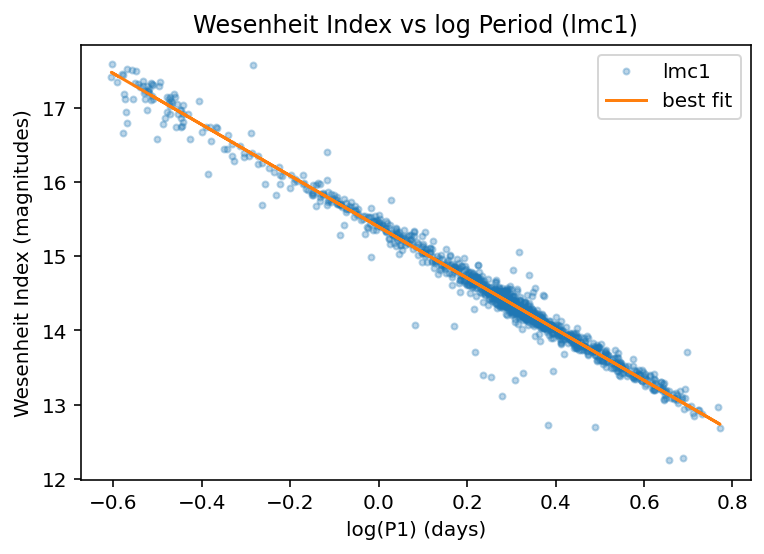

W =  -3.45 log(P1) +  15.396
Optimization terminated successfully.
         Current function value: 16.663204
         Iterations: 61
         Function evaluations: 121


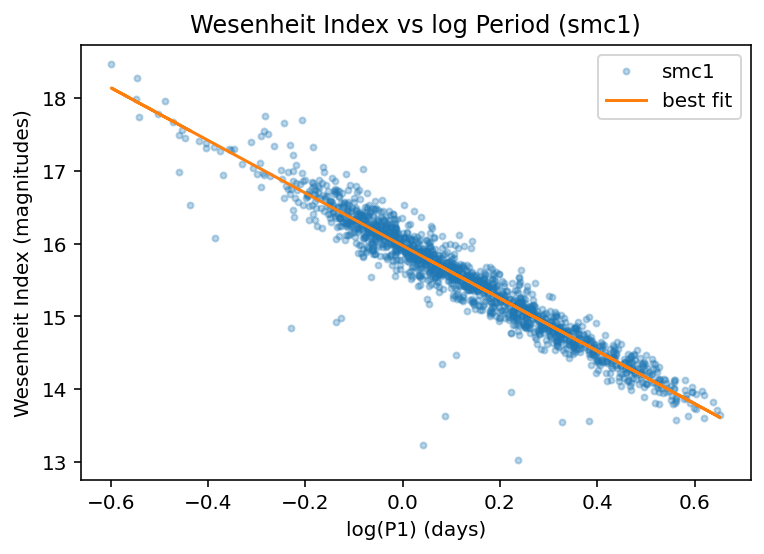

W =  -3.619 log(P1) +  15.971


In [27]:
def comp_huber_loss(m, b, x, y, delta):
    eq = ((y-(m*x+b)))
    if np.abs(eq)<=delta:
        huber_loss = ((eq)**2)/2
    else:
        huber_loss = delta*(np.abs(eq)-.5*delta)
    return huber_loss
def sum_huber(m,b,x,y,delta):
    summed=0
    for i in range(len(x)):
        summed += comp_huber_loss(m,b,x[i],y[i],delta)
    return summed

def f(params,x,y,delta):
    m,b = params
    return(sum_huber(m,b,x,y,delta))

guess = [1,1]
#lmcf
m1,b1 = optimize.fmin(f,guess,(np.asarray(lmcf.loc[:,"logP1"]),np.asarray(lmcf.loc[:,"W"]),.1))
plt.plot(lmcf.loc[:,"logP1"],lmcf.loc[:,"W"],".",label = 'lmcf',alpha=.3)
plt.plot(lmcf.loc[:,"logP1"],m1*lmcf.loc[:,"logP1"]+b1,label = 'best fit')
plt.xlabel("log(P1) (days)")
plt.ylabel("Wesenheit Index (magnitudes)")
plt.title("Wesenheit Index vs log Period (lmcf)")
plt.legend()
plt.show()
print('W = ', np.round(m1,3),'log(P1) + ',np.round(b1,3))

#smcf
m2,b2 = optimize.fmin(f,guess,(np.asarray(smcf.loc[:,"logP1"]),np.asarray(smcf.loc[:,"W"]),.1))
plt.plot(smcf.loc[:,"logP1"],smcf.loc[:,"W"],".",label = 'smcf',alpha=.3)
plt.plot(smcf.loc[:,"logP1"],m2*smcf.loc[:,"logP1"]+b2,label = 'best fit')
plt.xlabel("log(P1) (days)")
plt.ylabel("Wesenheit Index (magnitudes)")
plt.title("Wesenheit Index vs log Period (smcf)")
plt.legend()
plt.show()
print('W = ', np.round(m2,3),'log(P1) + ',np.round(b2,3))


#lmc1
m3,b3 = optimize.fmin(f,guess,(np.asarray(lmc1.loc[:,"logP1"]),np.asarray(lmc1.loc[:,"W"]),.1))
plt.plot(lmc1.loc[:,"logP1"],lmc1.loc[:,"W"],".",label = 'lmc1',alpha=.3)
plt.plot(lmc1.loc[:,"logP1"],m3*lmc1.loc[:,"logP1"]+b3,label = 'best fit')
plt.xlabel("log(P1) (days)")
plt.ylabel("Wesenheit Index (magnitudes)")
plt.title("Wesenheit Index vs log Period (lmc1)")
plt.legend()
plt.show()
print('W = ', np.round(m3,3),'log(P1) + ',np.round(b3,3))


#smc1
m4,b4 = optimize.fmin(f,guess,(np.asarray(smc1.loc[:,"logP1"]),np.asarray(smc1.loc[:,"W"]),.1))
plt.plot(smc1.loc[:,"logP1"],smc1.loc[:,"W"],".",label = 'smc1',alpha=.3)
plt.plot(smc1.loc[:,"logP1"],m4*smc1.loc[:,"logP1"]+b4,label = 'best fit')
plt.xlabel("log(P1) (days)")
plt.ylabel("Wesenheit Index (magnitudes)")
plt.title("Wesenheit Index vs log Period (smc1)")
plt.legend()
plt.show()
print('W = ', np.round(m4,3),'log(P1) + ',np.round(b4,3))



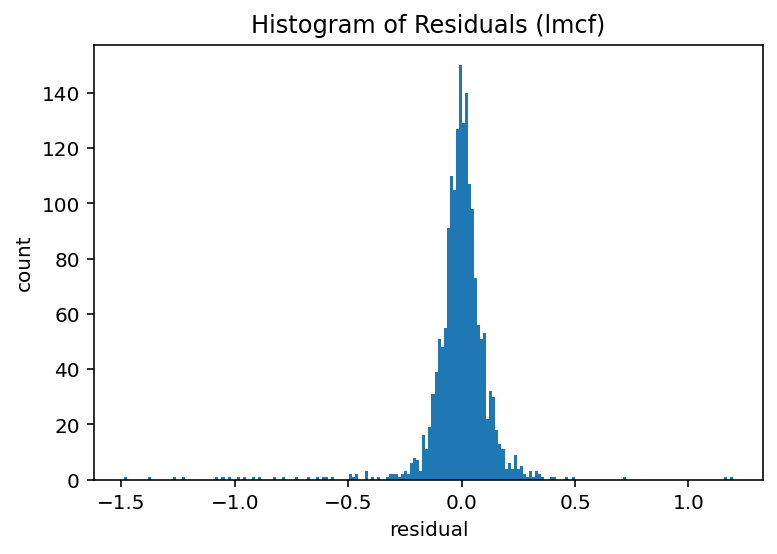

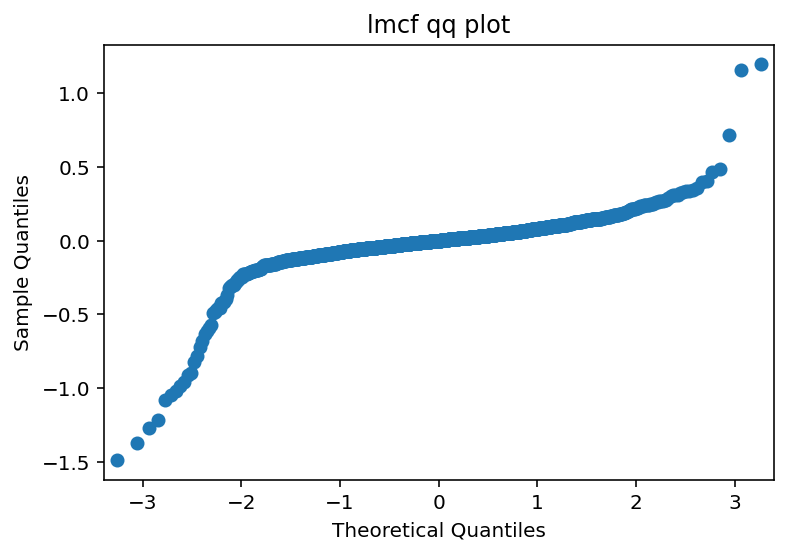

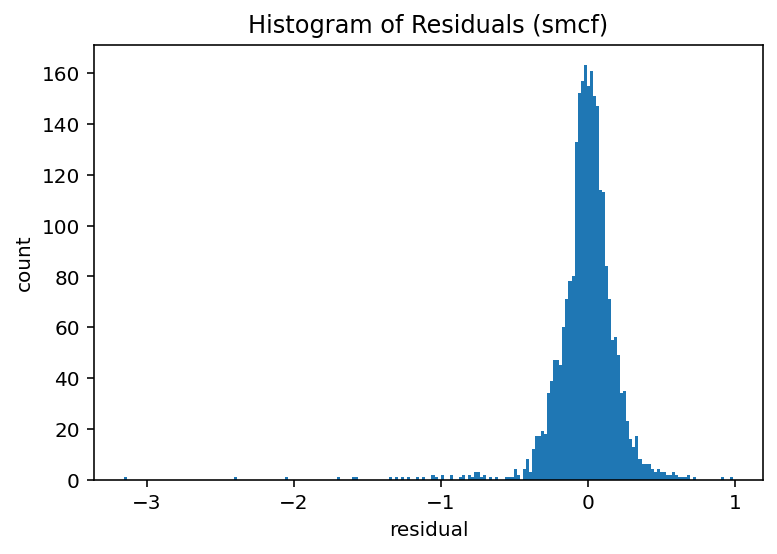

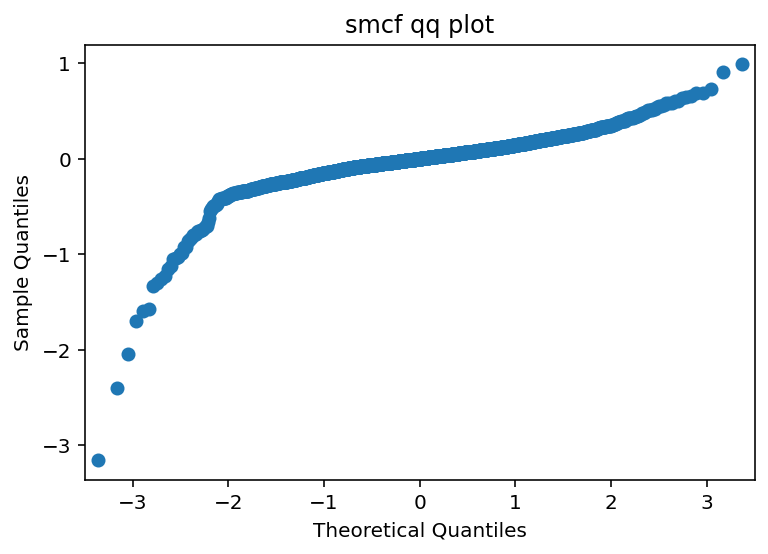

In [40]:
#Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution?
#If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

#lmcf
residuals1 = lmcf.loc[:,"W"]-m1*lmcf.loc[:,"logP1"]-b1
plt.hist(residuals1,bins=200)
plt.xlabel("residual")
plt.ylabel("count")
plt.title("Histogram of Residuals (lmcf)")
sm.qqplot(residuals1)
plt.title('lmcf qq plot')
plt.show()


#smcf
residuals2 = smcf.loc[:,"W"]-m2*smcf.loc[:,"logP1"]-b2
plt.hist(residuals2,bins=200)
plt.xlabel("residual")
plt.ylabel("count")
plt.title("Histogram of Residuals (smcf)")
sm.qqplot(residuals2)
plt.title('smcf qq plot')
plt.show()


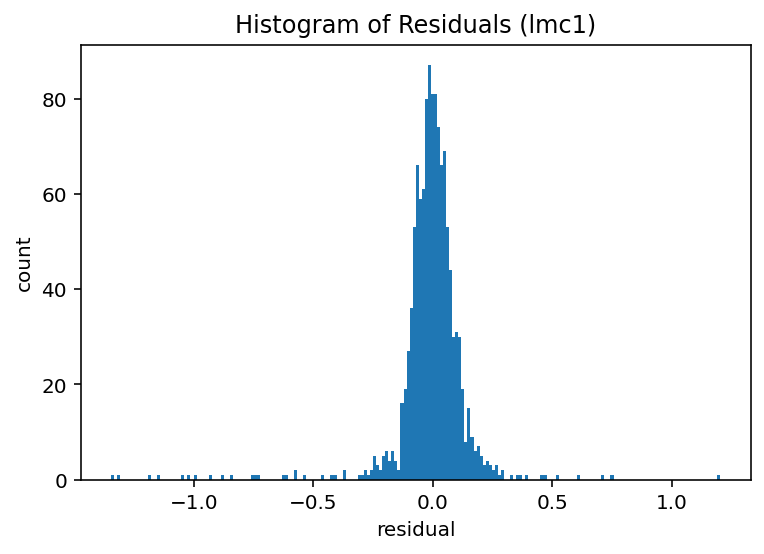

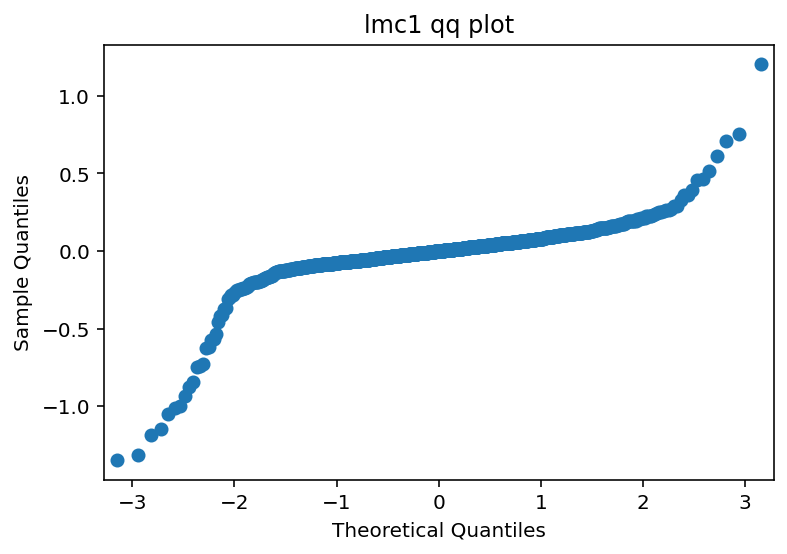

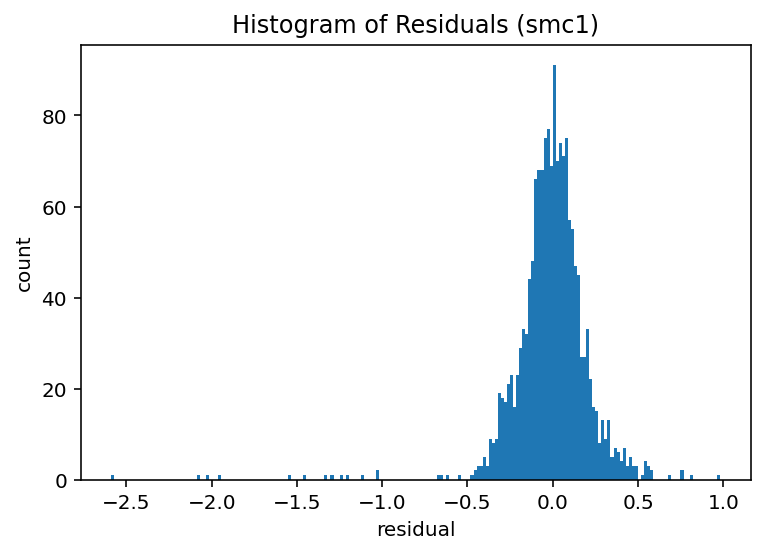

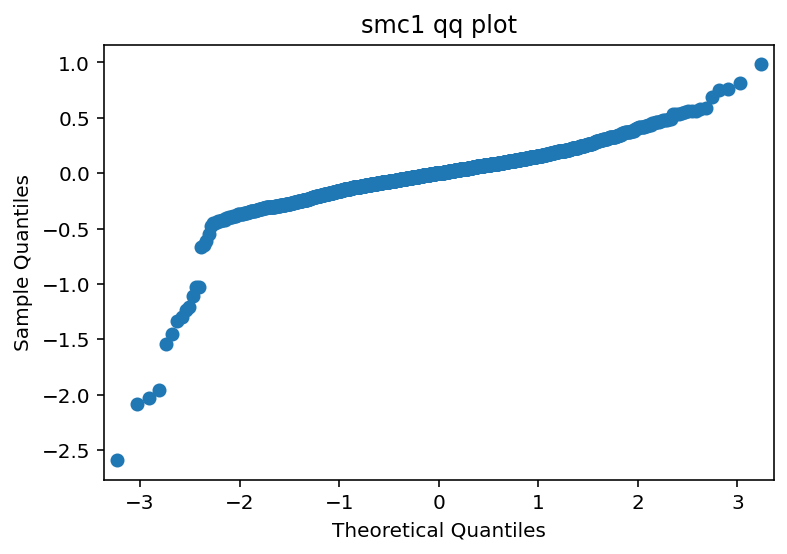

In [39]:

#lmc1
residuals3 = lmc1.loc[:,"W"]-m3*lmc1.loc[:,"logP1"]-b3
plt.hist(residuals3,bins=200)
plt.xlabel("residual")
plt.ylabel("count")
plt.title("Histogram of Residuals (lmc1)")
sm.qqplot(residuals3)
plt.title('lmc1 qq plot')
plt.show()

#smc1
residuals4 = smc1.loc[:,"W"]-m4*smc1.loc[:,"logP1"]-b4
plt.hist(residuals4,bins=200)
plt.xlabel("residual")
plt.ylabel("count")
plt.title("Histogram of Residuals (smc1)")
sm.qqplot(residuals4)
plt.title('smc1 qq plot')
plt.show()

These distributions look mostly normal, however they have long tails in the negative x direction. This means our model is more often overestimating the magnitude of stars. This could be caused by dust and extinction as our observations would appear dimmer than what the star truly is. However, this might not make complete sense becuase the Wesenheit index is meant to be insensitive to extinction. This could also be that there are extragalactic sources that our model doesn't account for.

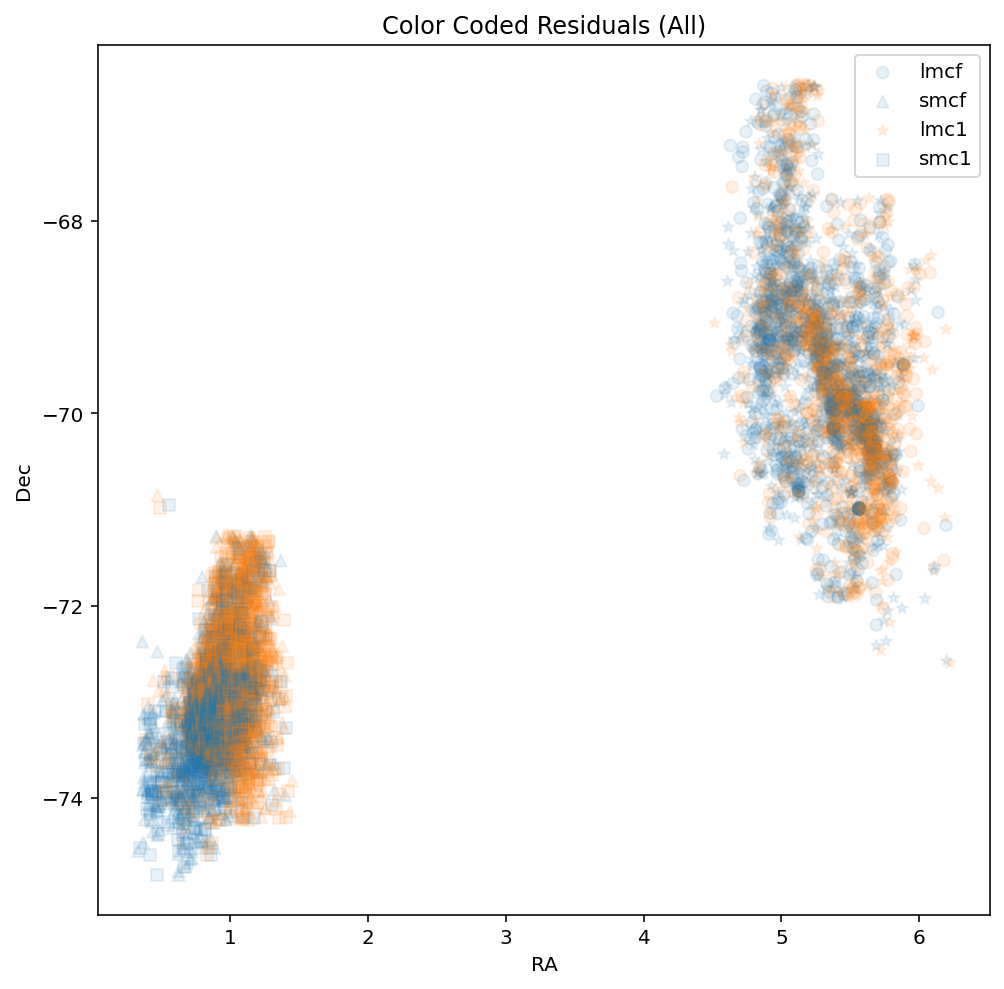

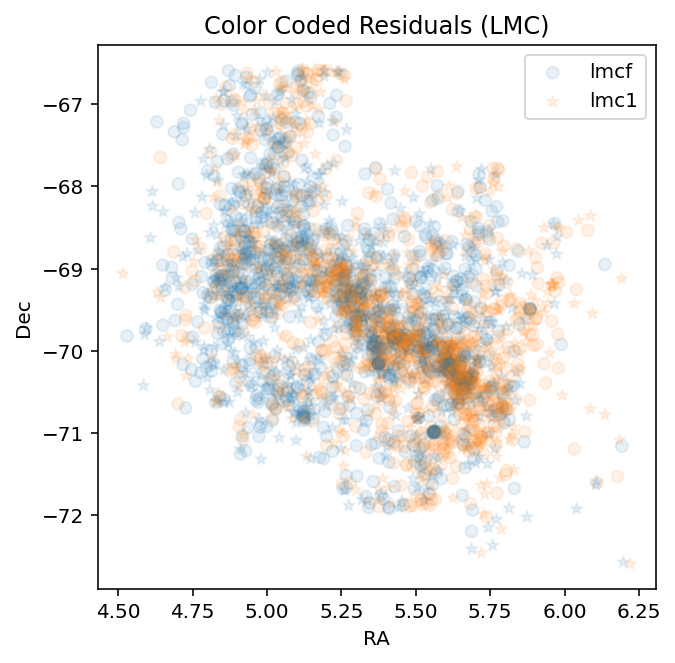

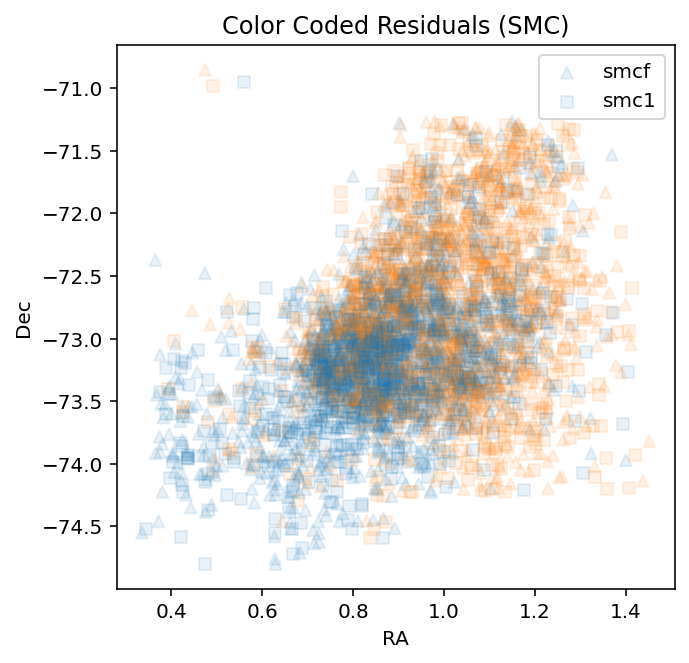

In [33]:
#Plot the residuals color coded by if they are positive or negative vs RA and Dec 
#(just like a Hess diagram in Problem 1). (15 pts)

#negative = orange
#positive = blue

color1 = []
for i in residuals1:
    if i>=0:
        color1.append("C0")
    else:
        color1.append("C1")
        
color2 = []
for i in residuals2:
    if i>=0:
        color2.append("C0")
    else:
        color2.append("C1")
        
color3 = []
for i in residuals3:
    if i>=0:
        color3.append("C0")
    else:
        color3.append("C1")
        
color4 = []
for i in residuals4:
    if i>=0:
        color4.append("C0")
    else:
        color4.append("C1")


plt.figure(figsize=(8, 8))     
plt.scatter(lmcf.loc[:,"RA0"],lmcf.loc[:,"Decl0"], c = color1,marker = 'o',alpha=.1 ,label ='lmcf')
plt.scatter(smcf.loc[:,"RA0"],smcf.loc[:,"Decl0"], c = color2,marker = '^',alpha=.1 ,label ='smcf')
plt.scatter(lmc1.loc[:,"RA0"],lmc1.loc[:,"Decl0"], c = color3 ,marker = '*',alpha=.1 ,label ='lmc1')
plt.scatter(smc1.loc[:,"RA0"],smc1.loc[:,"Decl0"], c = color4 ,marker = 's',alpha=.1 ,label ='smc1')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()
plt.title('Color Coded Residuals (All)')
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(lmcf.loc[:,"RA0"],lmcf.loc[:,"Decl0"], c = color1,marker = 'o',alpha=.1 ,label ='lmcf')
plt.scatter(lmc1.loc[:,"RA0"],lmc1.loc[:,"Decl0"], c = color3 ,marker = '*',alpha=.1 ,label ='lmc1')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()
plt.title('Color Coded Residuals (LMC)')
plt.show()

plt.figure(figsize=(5, 5))     
plt.scatter(smcf.loc[:,"RA0"],smcf.loc[:,"Decl0"], c = color2,marker = '^',alpha=.1 ,label ='smcf')
plt.scatter(smc1.loc[:,"RA0"],smc1.loc[:,"Decl0"], c = color4 ,marker = 's',alpha=.1 ,label ='smc1')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()
plt.title('Color Coded Residuals (SMC)')
plt.show()


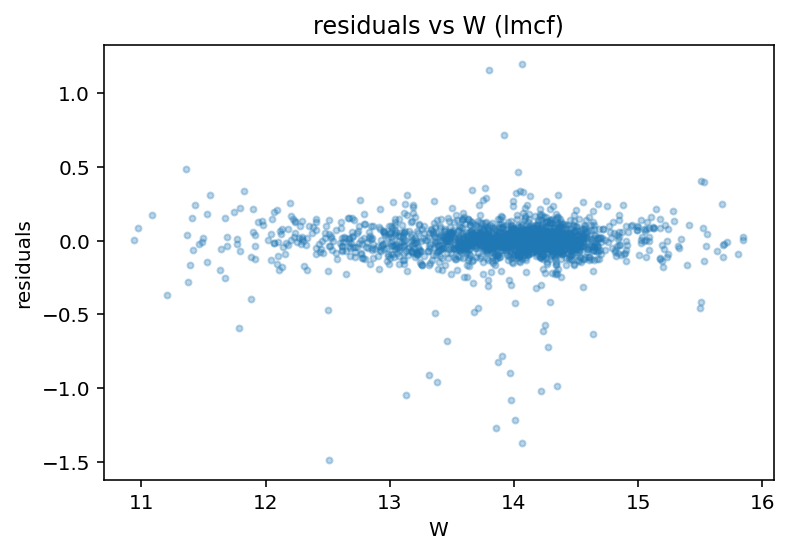

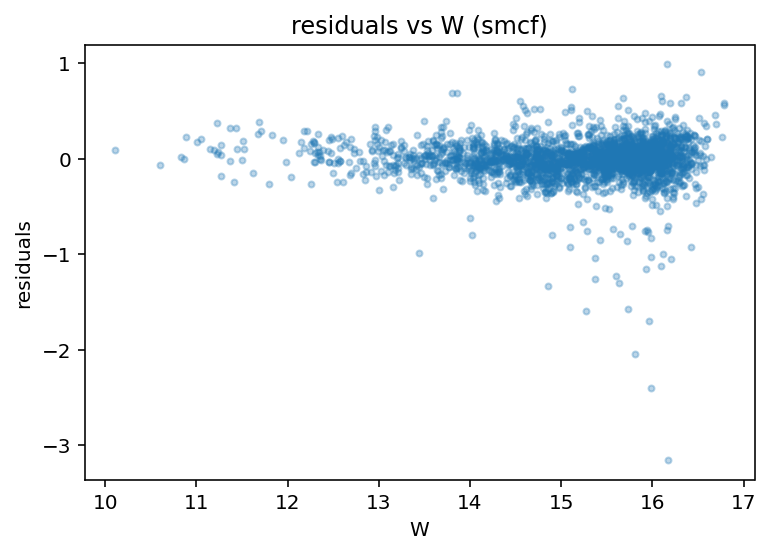

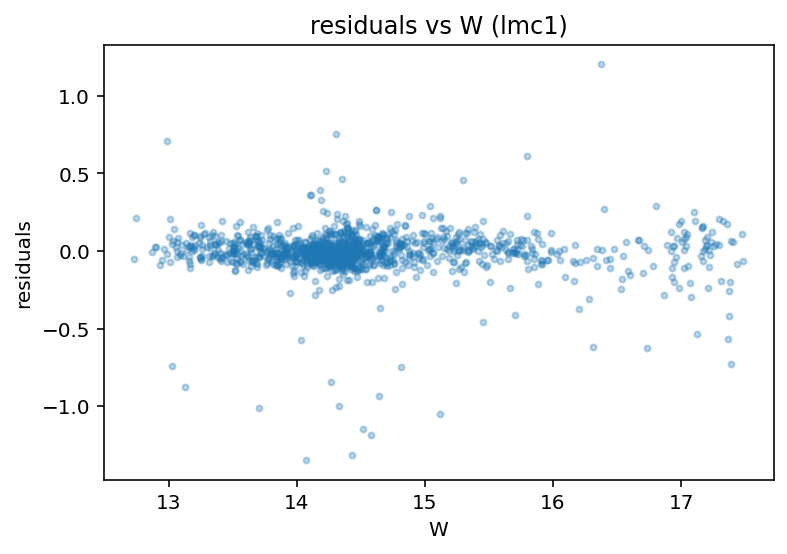

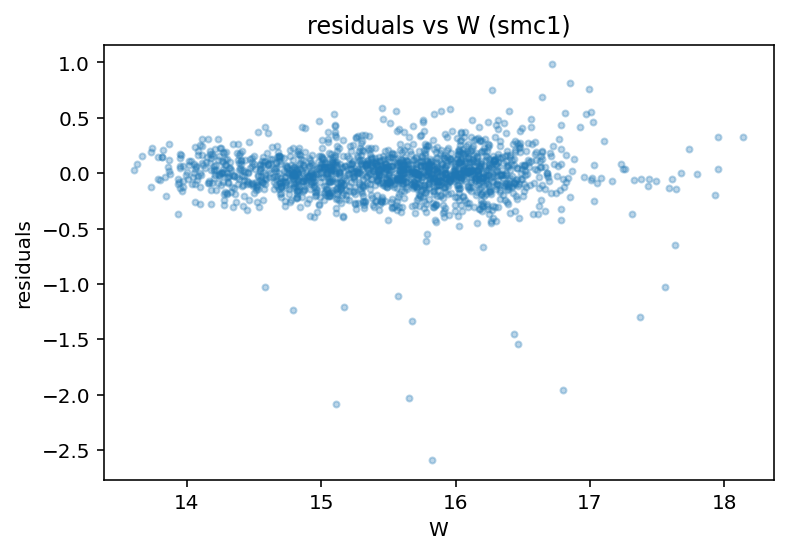

In [37]:
#Finally, plot the residuals against the fitted W values, and just to anticipate the next homework assignment, 
#also plot log(P1) vs V-I. Comment on what you are seeing. (15 pts)

plt.plot(m1*lmcf.loc[:,"logP1"]+b1,residuals1,'.',alpha=.3)
plt.title('residuals vs W (lmcf)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()
plt.plot(m2*smcf.loc[:,"logP1"]+b2,residuals2,'.',alpha=.3)
plt.title('residuals vs W (smcf)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()
plt.plot(m3*lmc1.loc[:,"logP1"]+b3,residuals3,'.',alpha=.3)
plt.title('residuals vs W (lmc1)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()
plt.plot(m4*smc1.loc[:,"logP1"]+b4,residuals4,'.',alpha=.3)
plt.title('residuals vs W (smc1)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()

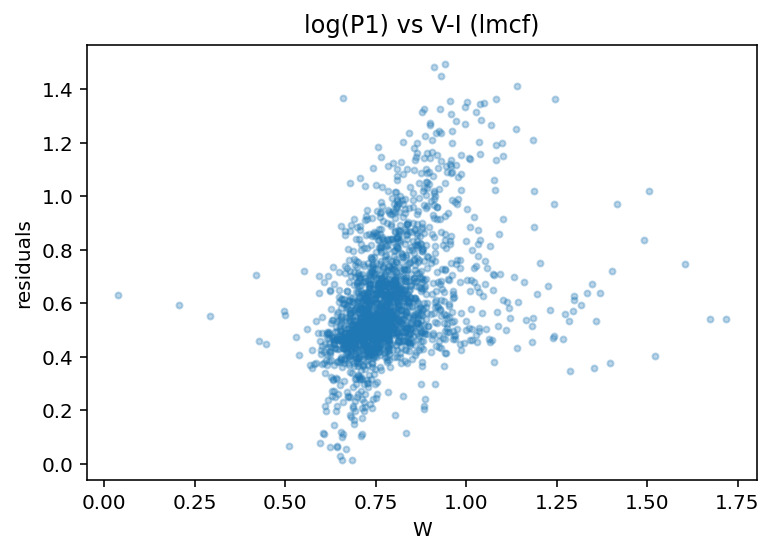

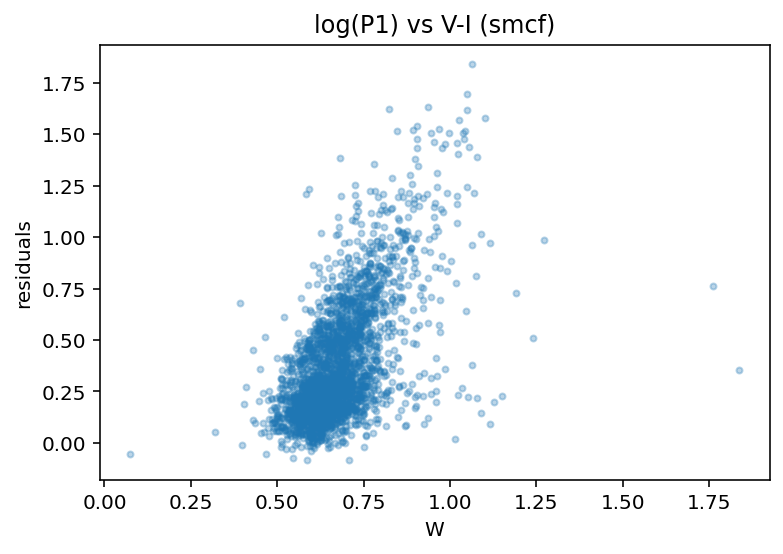

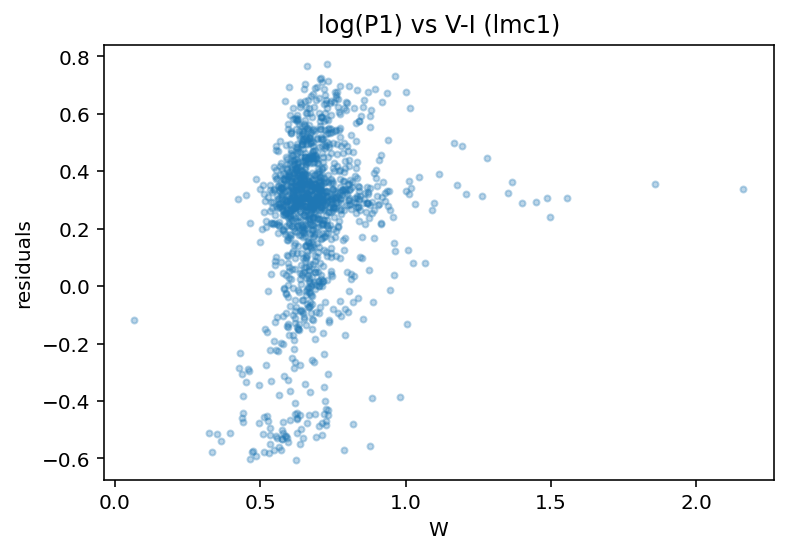

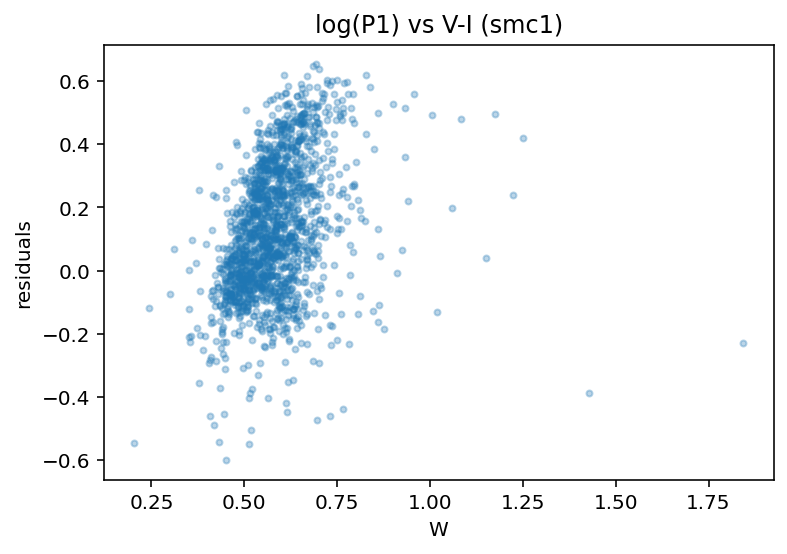

In [38]:
plt.plot(lmcf.loc[:,"VI"],lmcf.loc[:,"logP1"],'.',alpha=.3)
plt.title('log(P1) vs V-I (lmcf)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()
plt.plot(smcf.loc[:,"VI"],smcf.loc[:,"logP1"],'.',alpha=.3)
plt.title('log(P1) vs V-I (smcf)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()
plt.plot(lmc1.loc[:,"VI"],lmc1.loc[:,"logP1"],'.',alpha=.3)
plt.title('log(P1) vs V-I (lmc1)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()
plt.plot(smc1.loc[:,"VI"],smc1.loc[:,"logP1"],'.',alpha=.3)
plt.title('log(P1) vs V-I (smc1)')
plt.xlabel('W')
plt.ylabel('residuals')
plt.show()